# imports

In [71]:
import warnings
from importlib import reload
from collections import namedtuple
import inspect
from itertools import groupby
from datetime import date
from functional import seq
from functools import reduce, partial
from glob import glob
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
from hashlib import sha256
import json
import os
import pandas as pd
import pathlib
import pickle
import re
import seaborn as sns
import shutil
import cv2
#import skimage
#from skimage import io
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm, trange
import uuid
from IPython import display

%matplotlib inline
#plt.style.use("dark_background")

import sys
#from drosophpose.GUI import skeleton

from som_vae import somvae_model
from som_vae.utils import *

from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings.config import positional_data
from som_vae.helpers import video, plots
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
    
fix_layout()
enable_logging()

2019-05-03 13:23:36,031 - root - INFO - logging - logging enabled for level: 20


# data loading

In [2]:
#joint_positions = foldl(preprocessing.get_data(), 
#                        preprocessing.add_third_dimension,
#                        preprocessing.get_only_first_legs)[:, :, :config.NB_DIMS]
#
#NB_FRAMES = joint_positions.shape[0]
#__N_INPUT__ = len(config.LEGS) * config.NB_TRACKED_POINTS

In [3]:
from som_vae import settings

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

2019-05-03 12:27:00,168 - root - WARNING - preprocessing - this works only for the first legs!
2019-05-03 12:27:00,698 - root - WARNING - preprocessing - this works only for the first legs!
2019-05-03 12:27:02,603 - root - WARNING - preprocessing - this works only for the first legs!
2019-05-03 12:27:04,220 - root - WARNING - preprocessing - this works only for the first legs!
2019-05-03 12:27:04,909 - root - WARNING - preprocessing - this works only for the first legs!


## visual check of data

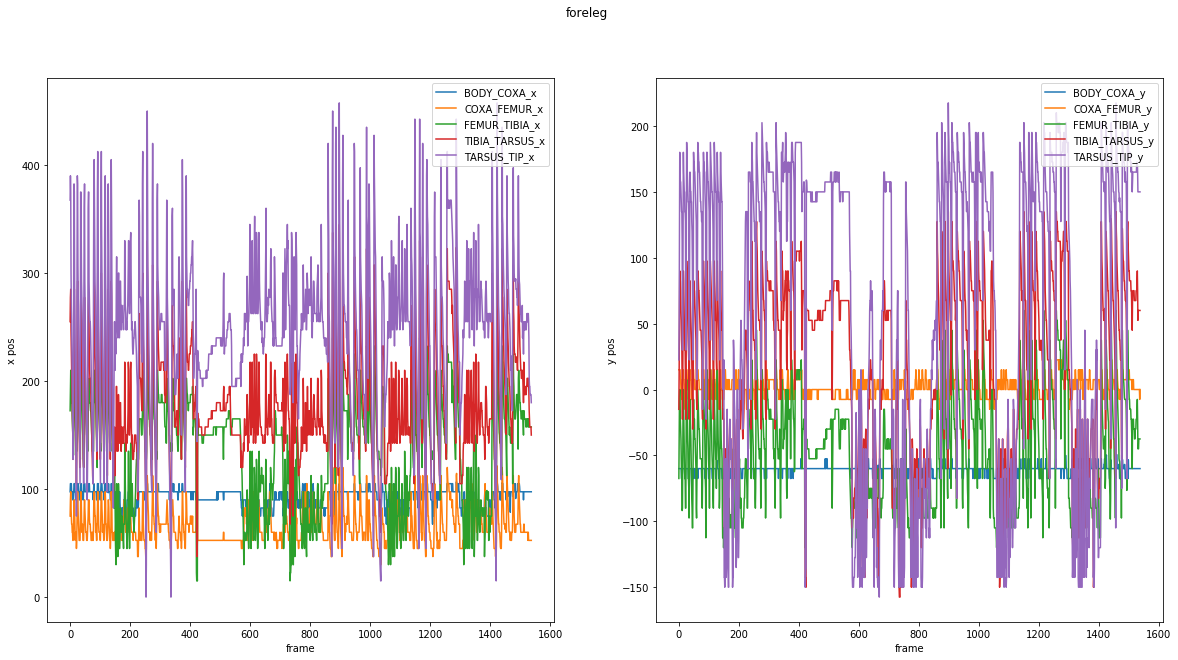

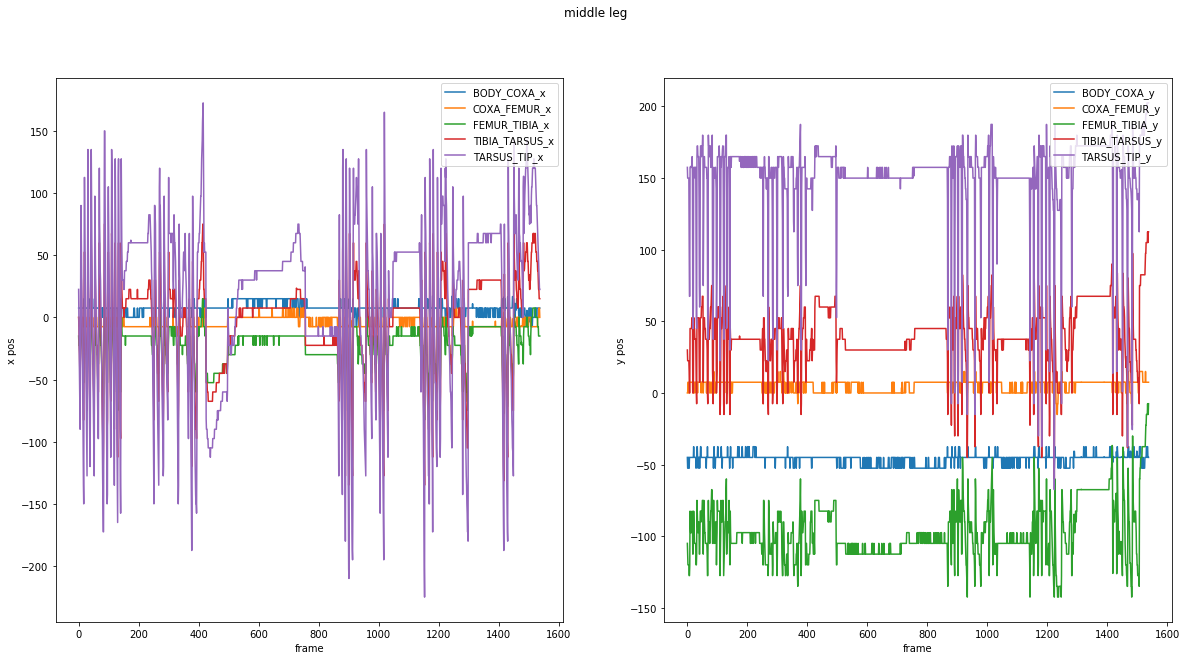

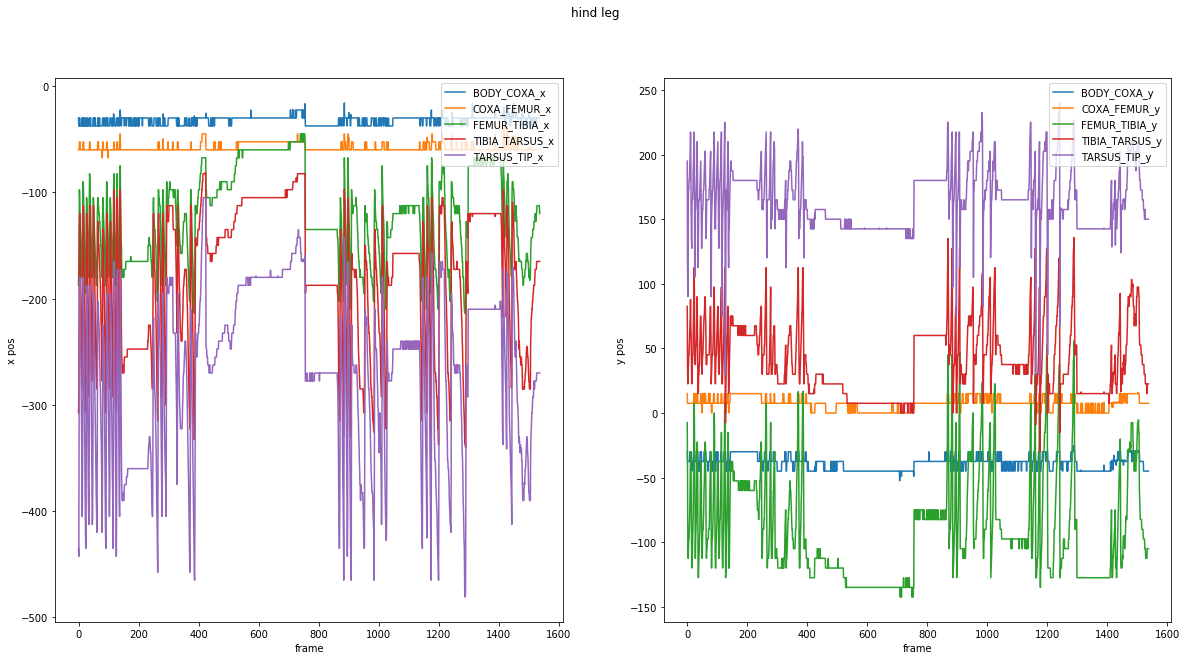

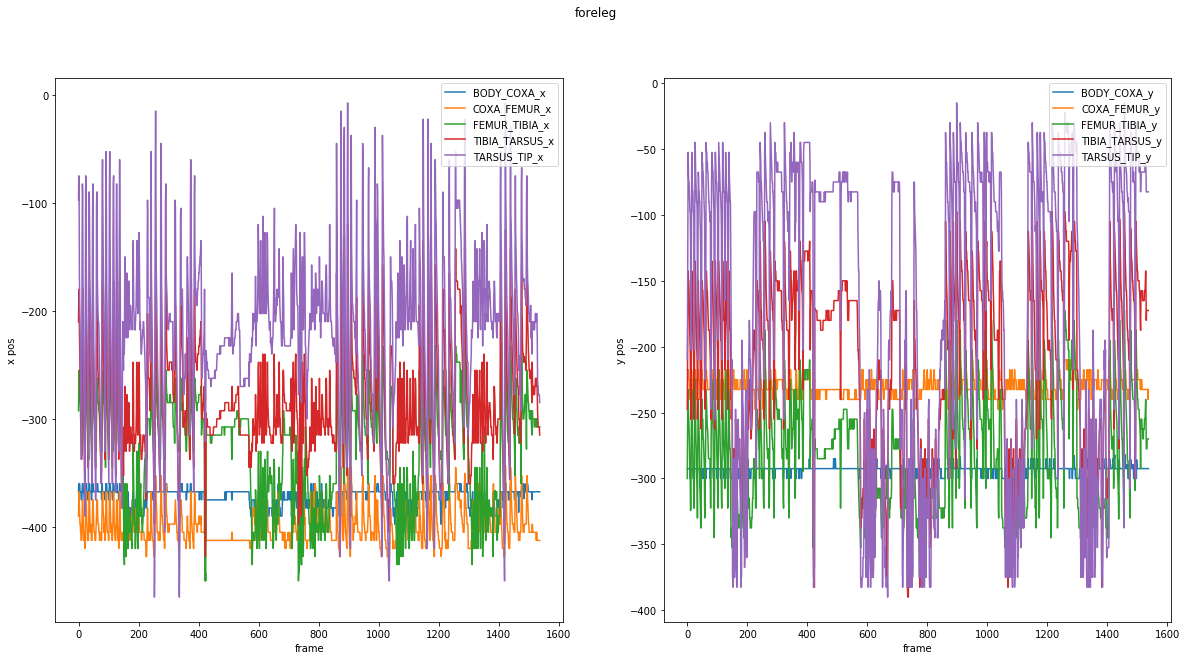

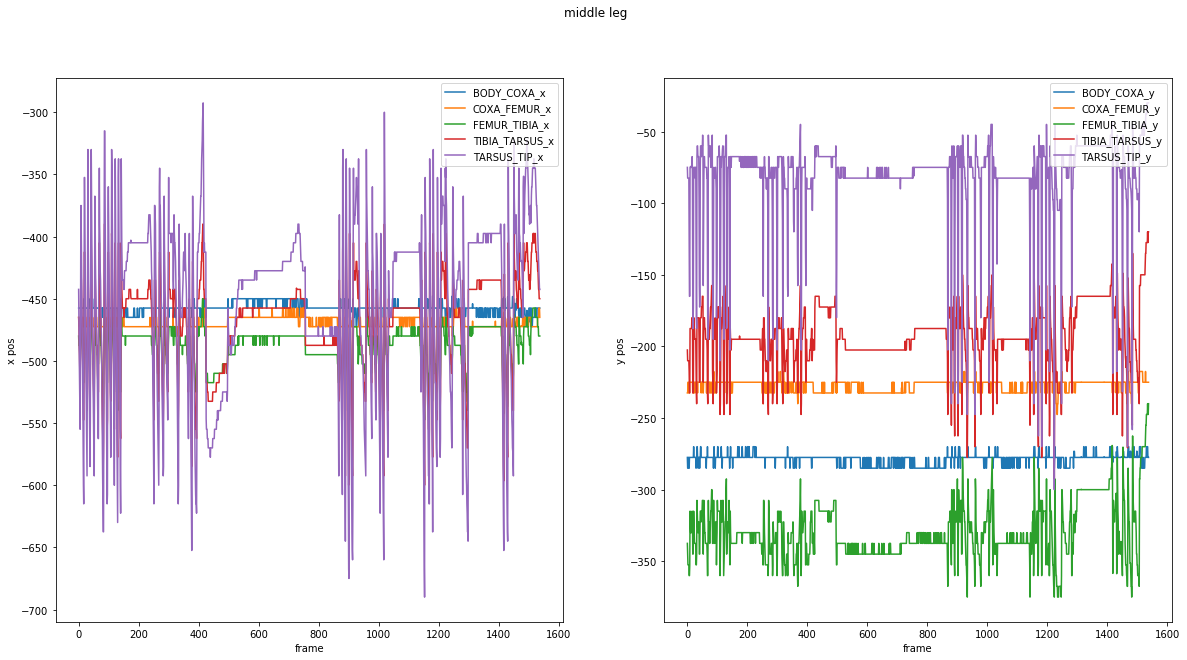

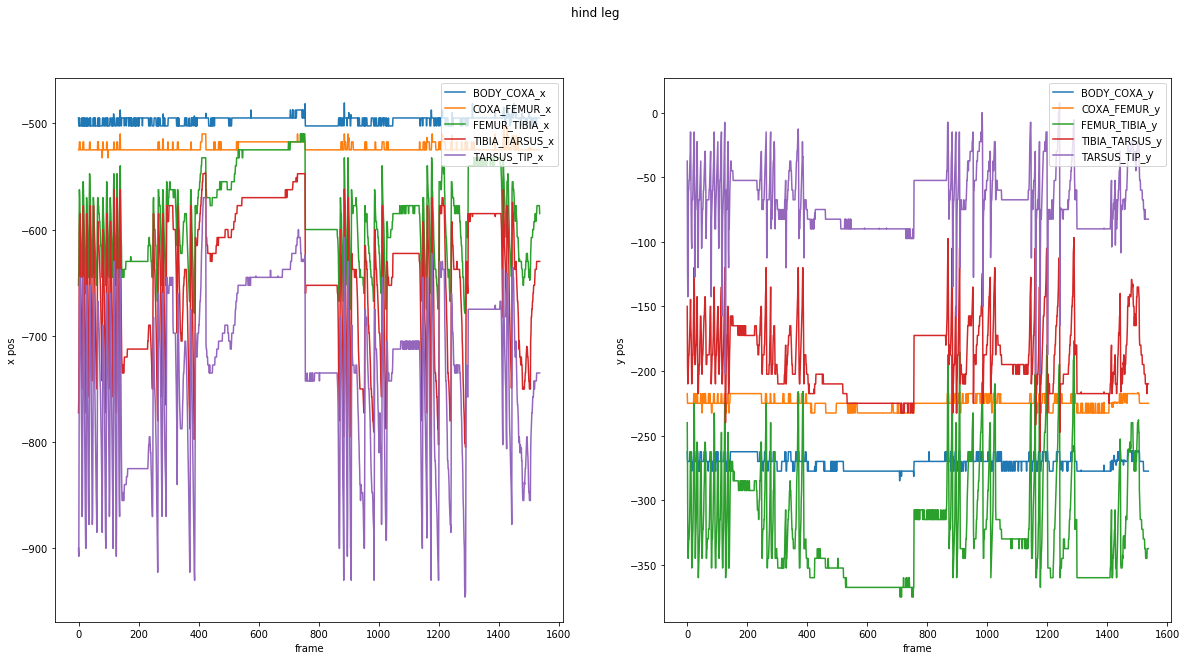

In [4]:
if True:
    plots.ploting_frames(joint_positions)
    plots.ploting_frames(joint_positions - normalisation_factors)

## loading of 3d data

In [5]:
def angle_three_points(a, b, c):
    """
    Given a set of any 3 points, (a,b,c), returns the angle ba^bc.
    """
    ba = a - b
    bc = c - b
 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle

In [75]:
def convert_3d_to_angle(data):
    data_angle = np.zeros((data.shape[0], data.shape[1]), dtype=np.float32)
    for img_id in range(data.shape[0]):
        for j_id in range(1, data.shape[1]-1):
            if any([fn(j_id) for fn in [skeleton.is_body_coxa, skeleton.is_tarsus_tip, skeleton.is_stripe, skeleton.is_antenna]]):
                continue
            data_angle[img_id, j_id] = angle_three_points(
                data[img_id, j_id - 1, :],
                data[img_id, j_id, :],
                data[img_id, j_id + 1, :])

    data_angle[np.isnan(data_angle) | np.isinf(data_angle)] = 0
    return data_angle

In [103]:
def get_3d_columns_names(selected_columns):
    return np.array([f"limb: {skeleton.limb_id[i]}: {p.name}" for i, p in enumerate(skeleton.tracked_points)])[selected_columns]

In [98]:
data_angle = np.vstack(seq(settings.data.EXPERIMENTS).map(lambda x: positional_data(x, dimensions='3d')))

data_angle = convert_3d_to_angle(data_angle)
data_angle_cols_of_interest = [2,7,12, 19+2, 19+4, 19+12]
data_angle_raw = data_angle.copy()
data_angle = data_angle[:, data_angle_cols_of_interest][frames_of_interest]

angled_data_columns = get_3d_columns_names(data_angle_cols_of_interest)

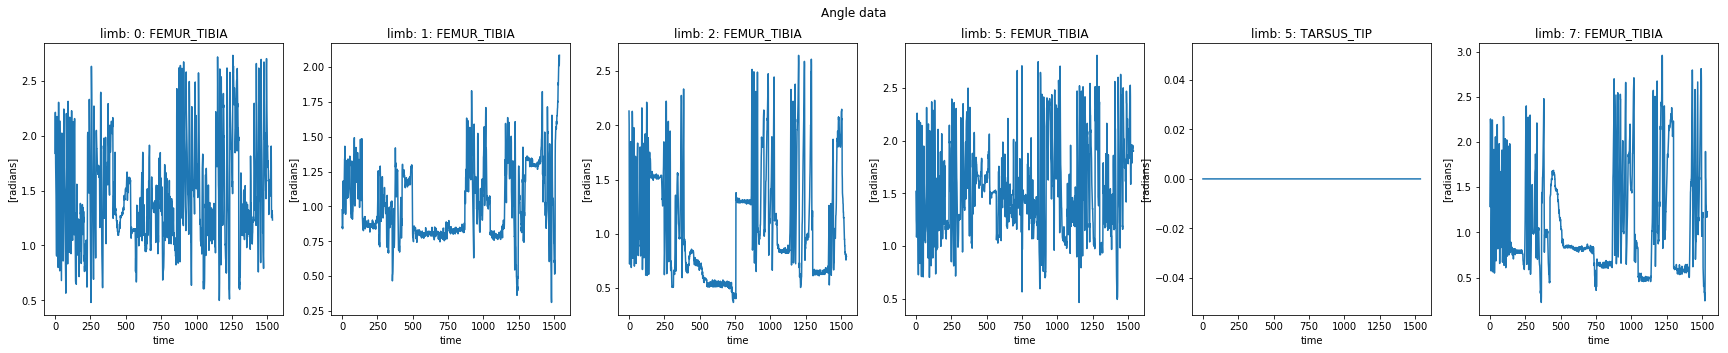

In [100]:
reload(plots)
plots.plot_angle_columns(data_angle, angled_data_columns);

### selection based on variance

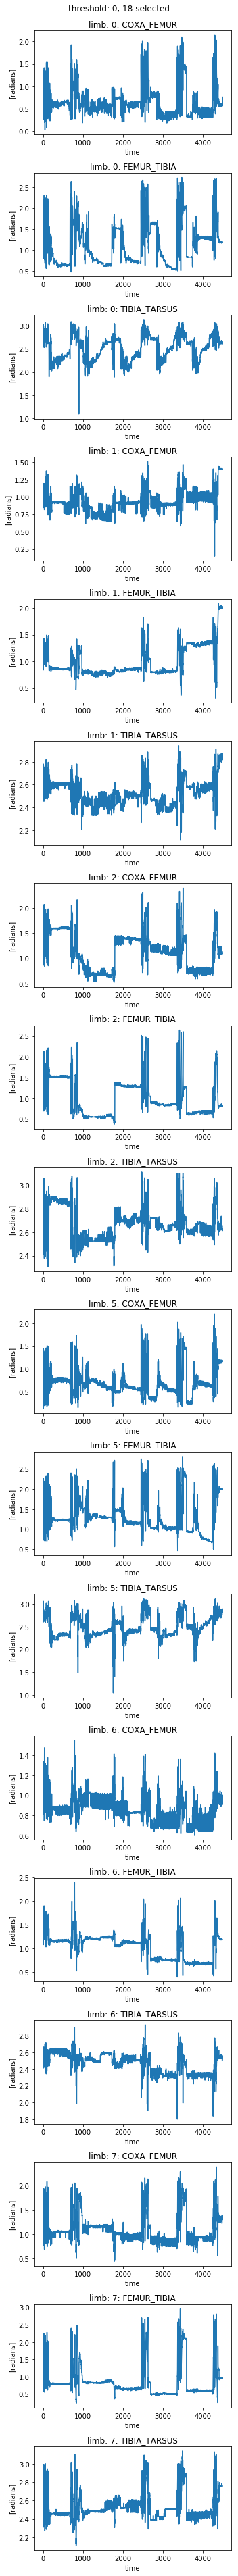

In [114]:
reload(plots)
threshold = 0
selected_cols = np.where(np.var(data_angle_raw, axis=0) > threshold)[0]
angled_data_columns = get_3d_columns_names(selected_cols)
f = plots.plot_angle_columns(data_angle_raw[:, selected_cols], angled_data_columns)
f.suptitle(f"threshold: {threshold}, {len(selected_cols)} selected");
plt.subplots_adjust(top=0.97)

In [80]:
warnings.warn('reselecting the columns based on variance')
data_angle = data_angle_raw[:, selected_cols]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: reselecting the columns based on variance
  """Entry point for launching an IPython kernel.


In [81]:
if config.NB_DIMS == 3:
    joint_positions, normalisation_factors = preprocessing.normalize(data_angle[frames_of_interest])
    data_angle_cols_of_interest = selected_cols

# SOM-VAE model

In [82]:
reload(somvae_model)

<module 'som_vae.somvae_model' from '/home/samuel/SOM-VAE/som_vae/somvae_model.py'>

## functions

In [83]:
def get_data_generator(data_train, labels_train, data_val, labels_val, time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            # TODO does the perumation make sense? if there is no time relationship -> yes
            #      but we argue that there is one, would perumutating it destroy this time relationship?
            indices = np.random.permutation(np.arange(len(images)))

            images = images[indices]
            labels = labels[indices]
            #if time_series:
            #    """It's a bit odd:
            #    
            #    1.) Take a random data point with the next label than the current one.
            #    2.) Interpolate from the current data point to the select one in <batch_size> steps
            #    3.) Add noise to it (normal)
            #    
            #    
            #    WILL NOT WORK ON PRODUCTION: what to do if no labels are available?
            #    """
            #    n_labels = len(np.unique(labels.reshape(-1)))
            #    for i, image in enumerate(images):
            #        start_image = image
            #        end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % n_labels)[0])]
            #        interpolation = interpolate_arrays(start_image, end_image, batch_size)
            #        yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            #else:
            for i in range(len(images)//batch_size):
                yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

In [84]:
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()
    
    with tf.Session(config=_TF_DEFAULT_SESSION_CONFIG_) as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        train_losses = []
        test_losses = []
        test_losses_reconstrution = []
        train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
        test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary, test_loss_reconstruction = sess.run([model.loss, summaries, model.loss_reconstruction], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_losses_reconstrution.append(test_loss_reconstruction)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                        train_losses += [train_loss]
                        
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()
                
    return test_losses, train_losses, test_losses_reconstrution

In [85]:
def evaluate_model(model, x, modelpath, batch_size, data, labels=None, tf_session_config=None):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
        x hat, reconstructed data
        cluster assignments for each row
        encoding of x
    """
    if tf_session_config is None:
        tf_session_config = _TF_DEFAULT_SESSION_CONFIG_
    
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    
    num_batches = len(data)//batch_size
    
    def _concat_(xs):
        if len(xs[0].shape) == 1:
            return np.hstack(xs)
        else:
            return np.vstack(xs)
    
    with tf.Session(config=tf_session_config) as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        #everything = [sess.run([model.k,  model.x_hat_embedding, model.x_hat_encoding, model.z_e],  feed_dict={x: batch_data}) for batch_data in chunks(data, num_batches)]
        cluster_assignments, x_hat_embedding, x_hat_encoding, x_hat_latent = [_concat_(_r) for _r in  
                                                                              zip(*[sess.run([model.k,  
                                                                                              model.x_hat_embedding,
                                                                                              model.x_hat_encoding,
                                                                                              model.z_e],  feed_dict={x: batch_data}) 
                                                                                    for batch_data in chunks(data, num_batches)])]

        cluster_assignments = cluster_assignments.reshape(-1)
        mse_encoding = mean_squared_error(x_hat_encoding.flatten(), data.flatten())
        mse_embedding = mean_squared_error(x_hat_embedding.flatten(), data.flatten())
        #if labels is not None:
        #    nmi = compute_NMI(cluster_assignments.tolist(), labels[:len(cluster_assignments)])
        #    purity = compute_purity(cluster_assignments.tolist(), labels[:len(cluster_assignments)])

    results = {}
    #results["NMI"] = nmi 
    #results["Purity"] = purity 
    results["MSE (encoding)"] = mse_encoding 
    results["MSE (embedding)"] = mse_embedding 
    results["nb of used clusters"] = len(np.unique(cluster_assignments))
#    results["optimization_target"] = 1 - test_nmi

    return results, x_hat_embedding, cluster_assignments, x_hat_encoding, x_hat_latent

In [86]:
def model_main(X_train, X_val, y_train, y_val, latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, image_like_input, time_series, config):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    print(f"running with config: {config}")
    ## TODO
    #input_shape: e.g. (15, 1)  for flat data (flattened tabular)
    #                  (28, 28, 3) for image like data
   
    if config['image_like_input']:
        raise NotImplementedError
        input_length = __NB_DIMS__
        input_channels = __N_INPUT__
        x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels, 1]) # for image
    else:
        input_length = config['input_length']
        #input_channels = __N_INPUT__ * __NB_DIMS__
        input_channels = config['input_channels']
        #x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels]) 
        placeholder_shape = [None, *X_train.shape[1:]]
        print(f"placeholder_shape: {placeholder_shape}")
        x = tf.placeholder(tf.float32, shape=placeholder_shape) 
        
    data_generator = get_data_generator(data_train=X_train, data_val=X_val, labels_train=y_train, labels_val=y_val,time_series=time_series)

    lr_val = tf.placeholder_with_default(learning_rate, [])

    # TODO pack all these variables in a config, at the end of the project extract them again
    model = somvae_model.SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, image_like_input=image_like_input, config=config)

    test_losses, train_losses, test_losses_reconstruction = train_model(model, x, lr_val, generator=data_generator, **extract_args(config, train_model))

    result =     evaluate_model(model, x, data=X_train, labels=y_train, **extract_args(config, evaluate_model))
    result_val = evaluate_model(model, x, data=X_val,   labels=y_val,   **extract_args(config, evaluate_model))
    

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))
        
    print(f"got (train): {result[0]}")
    print(f"got (val: {result_val[0]}")

    return result, model, (train_losses, test_losses, test_losses_reconstruction), result_val

## model config

In [87]:
## config

if config.NB_DIMS == 2:
    _latent_dim_ = 16
    _input_channels_ = joint_positions.shape[1] * config.NB_DIMS,
else:
    _latent_dim_ = int(np.sqrt(data_angle.shape[1]))
    _input_channels_ = joint_positions.shape[1]

_som_dim = [8,8]

som_vae_config = {
    "num_epochs": 400,
    "patience": 100,
    "batch_size": 30, # len(joint_positions), # if time_series then each batch should be a time series
    "latent_dim": _latent_dim_,
    "som_dim": _som_dim,
    "learning_rate": 0.0005,
    #"alpha": 0.0, #1.0,
    #"beta": 0.0, #0.9,
    #"gamma": 0.0, #1.8,
    #"tau": 0.0, # 1.4,
    "alpha": 0.0,                          # commit loss
    "beta": 0.0,                           # loss som
    "gamma": 0.0,                          # loss proba
    "tau": 0.0,                            # loss z proba
    "loss_reconstruction_encoding": 1.0,
    "loss_reconstruction_embedding": 0.0,
    "decay_factor": 0.9,
    "interactive": True, # this is just for the progress bar
    "data_set": "MNIST_data",
    "save_model": False,
    "time_series": True,
    "image_like_input": False,
    "activation_fn": "relu", # or relu -> with normalisation layer?
    "input_channels": _input_channels_,
    "input_length": 1,
    "time_sequence_length": 10
}

if all(som_vae_config[l] == 0.0 for l in ['alpha', 'beta', 'gamma', 'tau']):
    _loss_description_ = 'only-recon-loss'
else:
    _loss_description_ = 'all-losses'
    
if som_vae_config['time_series']:
    _time_series_description_ = 'as-time-series'
else:
    _time_series_description_ = 'no-time-series'
    
_name_ = f"{config.NB_DIMS}d-{_loss_description_}_{_time_series_description_}"
som_vae_config['name'] = _name_
_ex_name_ = "{}_{}_{}-{}_{}_{}".format(_name_, _latent_dim_, _som_dim[0], _som_dim[1], datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), sha256(json.dumps(som_vae_config, sort_keys=True).encode()).hexdigest()[:5])
som_vae_config['ex_name'] = _ex_name_
 
som_vae_config["logdir"] = "../neural_clustering_data/logs/{}".format(_ex_name_)
som_vae_config["modelpath"] = "../neural_clustering_data/models/{0}/{0}.ckpt".format(_ex_name_)

In [88]:
# creating path to store model
pathlib.Path(som_vae_config['modelpath']).parent.mkdir(parents=True, exist_ok=True)
pathlib.Path(som_vae_config['logdir']).parent.mkdir(parents=True, exist_ok=True)

_MODEL_CONFIG_PATH_ = pathlib.Path(som_vae_config['logdir']).parent.parent / 'model_configs'
_MODEL_CONFIG_PATH_.mkdir(exist_ok=True)
with open(f"{_MODEL_CONFIG_PATH_}/{som_vae_config['ex_name']}.json", 'w') as f:
    json.dump(som_vae_config, f)

In [89]:
assert not(som_vae_config['time_series'] and config.NB_DIMS == 2), 'this does not work right now'

## data processing

In [90]:
def to_time_series(data, sequence_length=som_vae_config['time_sequence_length']):
    for i in range(len(data)):
        if i + sequence_length <= len(data):
            yield data[i:i+sequence_length]

In [91]:
joint_positions.shape

(1538, 18)

In [92]:
# flatten the data
if config.NB_DIMS == 2:
    reshaped_joint_position = joint_positions[:,:,: config.NB_DIMS].reshape(joint_positions.shape[0], -1)
else:
    reshaped_joint_position = joint_positions
print(f"shape of input data:{reshaped_joint_position.shape}")

# TODO move scaler back down
warnings.warn('scaling at this point is not good science, this is just a quick fix')
scaler = MinMaxScaler()
reshaped_joint_position = scaler.fit_transform(reshaped_joint_position)


if som_vae_config['time_series']:
    # duplicating the elements, e.g.: [0, 1, 2], [1, 2, 3], [2, 3, 4], ...
    # this has a sequence length of 3
    _time_series_idx_ = list(to_time_series(range(len(joint_positions))))
    _jp = np.concatenate([reshaped_joint_position[idx].reshape(1, -1, reshaped_joint_position.shape[1]) for idx in _time_series_idx_], axis=0)\
            .reshape(-1, som_vae_config['time_sequence_length'] * reshaped_joint_position.shape[1])
    som_vae_config['input_channels'] = som_vae_config['time_sequence_length'] * reshaped_joint_position.shape[1]
else:
    som_vae_config['input_length'] = 1
    som_vae_config['input_channels'] = reshaped_joint_position.shape[1]
    _jp = reshaped_joint_position 
    
assert np.product(_jp.shape[1:]) > som_vae_config['latent_dim'],\
       'latent dimension should be strictly smaller than input dimensions, otherwise it\'s not really a VAE...'
    
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
# train - test split
nb_of_data_points = int(_jp.shape[0] * 0.7)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
#resh = scaler.fit_transform(resh)
#data_train = scaler.fit_transform(_jp[:nb_of_data_points])
#data_test = scaler.transform(_jp[nb_of_data_points:])

data_train = _jp[:nb_of_data_points]
data_test = _jp[nb_of_data_points:]

# just generating some labels, no clue what they are for except validation?
labels = frames_idx_with_labels['label'].apply(lambda x: x.value).values

if som_vae_config['time_series']:
    labels = np.concatenate([labels[idx].reshape(1, -1, 1) for idx in _time_series_idx_], axis=0)[:,-1]

data = {
  "X_train": data_train,
  "X_val": data_test,
  "y_train": labels[:nb_of_data_points],
  "y_val": labels[nb_of_data_points:]
}

for k, v in data.items():
    print(k, v.shape)

shape of input data:(1538, 18)
X_train (1070, 180)
X_val (459, 180)
y_train (1070, 1)
y_val (459, 1)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: scaling at this point is not good science, this is just a quick fix
  if __name__ == '__main__':


## running fit & test

In [93]:
reload(somvae_model)

tf.reset_default_graph()

_args = inspect.getfullargspec(model_main).args
res, mdl, losses, res_val = model_main(**{**{k:som_vae_config[k] for k in _args if k in som_vae_config}, **data, "config": som_vae_config})

running with config: {'num_epochs': 400, 'patience': 100, 'batch_size': 30, 'latent_dim': 4, 'som_dim': [8, 8], 'learning_rate': 0.0005, 'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0, 'tau': 0.0, 'loss_reconstruction_encoding': 1.0, 'loss_reconstruction_embedding': 0.0, 'decay_factor': 0.9, 'interactive': True, 'data_set': 'MNIST_data', 'save_model': False, 'time_series': True, 'image_like_input': False, 'activation_fn': 'relu', 'input_channels': 180, 'input_length': 1, 'time_sequence_length': 10, 'name': '3d-only-recon-loss_as-time-series', 'ex_name': '3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87', 'logdir': '../neural_clustering_data/logs/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87', 'modelpath': '../neural_clustering_data/models/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87.ckpt'}
placeholder_shape: [None, 180]
embeddings shape in z_dist_flat: (8, 8, 4), and exp

  0%|          | 0/14000 [00:00<?, ?it/s]

Training...


 36%|███▌      | 5040/14000 [00:46<01:22, 108.43it/s, epoch=143, test_loss=0.06, train_loss=0.0272]  


INFO:tensorflow:Restoring parameters from ../neural_clustering_data/models/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87.ckpt


2019-05-03 14:30:11,059 - tensorflow - INFO - saver - Restoring parameters from ../neural_clustering_data/models/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87.ckpt


INFO:tensorflow:Restoring parameters from ../neural_clustering_data/models/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87.ckpt


2019-05-03 14:30:11,448 - tensorflow - INFO - saver - Restoring parameters from ../neural_clustering_data/models/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87/3d-only-recon-loss_as-time-series_4_8-8_2019-05-03_14-19-39_80b87.ckpt


got (train): {'MSE (encoding)': 0.006124298, 'MSE (embedding)': 0.020092947, 'nb of used clusters': 4}
got (val: {'MSE (encoding)': 0.02320153, 'MSE (embedding)': 0.03311231, 'nb of used clusters': 4}


In [94]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    if input_shape is None:
        if config.NB_DIMS == 2:
            input_shape = (-1, config.NB_DIMS)
        else:
            input_shape = (-1,)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))


def _time_series_reverser_(xs, is_time_series=som_vae_config['time_series'], original_size=None):
    if is_time_series:
        if config.NB_DIMS == 3:
            return xs.reshape(-1, som_vae_config['time_sequence_length'], joint_positions.shape[1])[:, -1]
        else:
            return xs.reshape
    else:
        return xs

reconstructed_from_embedding_train =  _reverse_to_original_shape_(_time_series_reverser_(res[1]))
reconstructed_from_embedding_val   =  _reverse_to_original_shape_(_time_series_reverser_(res_val[1]))
reconstructed_from_encoding_train  =  _reverse_to_original_shape_(_time_series_reverser_(res[3]))
reconstructed_from_encoding_val    =  _reverse_to_original_shape_(_time_series_reverser_(res_val[3]))

<Figure size 1080x576 with 0 Axes>

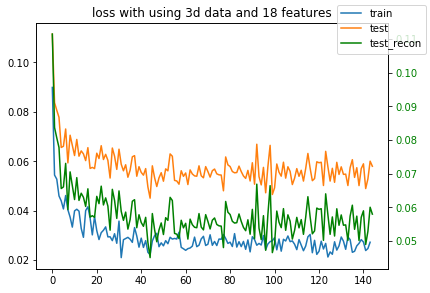

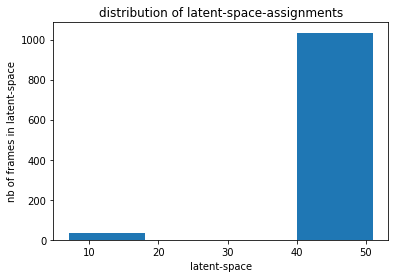

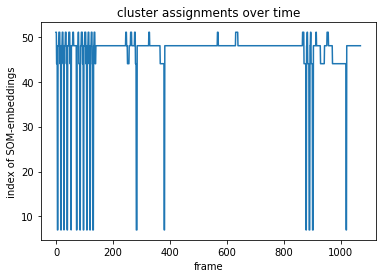

In [95]:
f =plots.plot_losses(losses, title=f'using {config.NB_DIMS}d data and {joint_positions.shape[1]} features')
p = f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_losses.png"
pathlib.Path(p).parent.mkdir(exist_ok=True)
f.savefig(p)
plots.plot_latent_frame_distribution(res[2], nb_bins=_latent_dim_)
plots.plot_cluster_assignment_over_time(res[2])

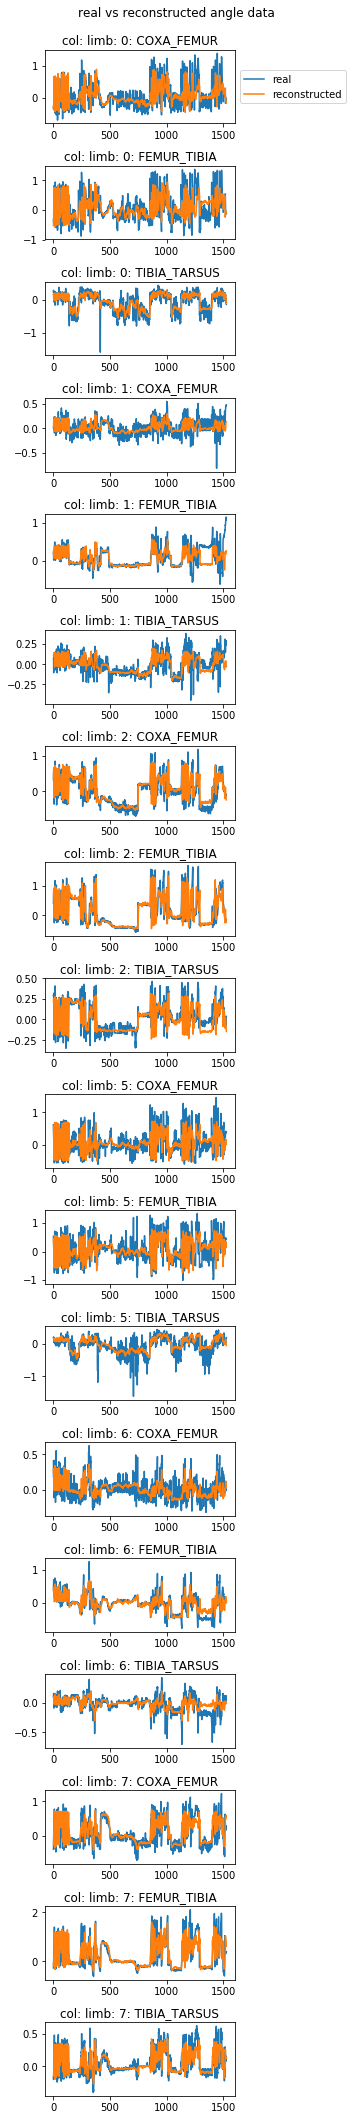

In [125]:
reload(plots)
if config.NB_DIMS == 3:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]
    else:
        timed_jp = joint_positions
        
    f = plots.plot_reconstructed_angle_data(real_data=timed_jp,
                                            reconstructed_data=np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                            columns=angled_data_columns)
    p = f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_angled_plot_.png"
    pathlib.Path(p).parent.mkdir(exist_ok=True)
    f.savefig(p)
else:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]

        plots.plot_comparing_joint_position_with_reconstructed(timed_jp, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)
    else:
        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)

        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val)), 
                                                               validation_cut_off=nb_of_data_points)

In [129]:
from numpy.lib.index_tricks import s_

def mean_squared_difference(a, b):
    return ((a - b) ** 2).mean()


if not som_vae_config['time_series']:
    # the problem is the train-test split point... not super hard to figure out...
    _n_train_ = len(res[3])
    _idx_ = (s_[:_n_train_,:,:config.NB_DIMS], s_[_n_train_:,:,:config.NB_DIMS]) * 2
    _order_split_ = ['train', 'test'] * 2
    _order_ = ['encoding'] * 2 + ['embedding'] * 2
    _loop_data_ = (reconstructed_from_encoding_train, reconstructed_from_encoding_val, reconstructed_from_embedding_train, reconstructed_from_embedding_val)

    for i, o, order_split, d in zip(_idx_, _order_, _order_split_, _loop_data_):
        if som_vae_config['time_series']:
            print(f"MSE for {o}\t{order_split}:\t{mean_squared_difference(timed_jp[i], d)}")
        else:
            print(f"MSE for {o}\t{order_split}:\t{mean_squared_difference(joint_positions[i], d)}")

## cool videos 

In [131]:
if som_vae_config['time_series']:
    raise ValueError('videos and such are not yet done for 3d data')

ValueError: videos and such are not yet done for 3d data

In [ ]:
def reverse_pos_pipeline(x, normalisation_term=normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_term[:x.shape[-1]]

In [ ]:
from som_vae.helpers.video import _float_to_int_color_

In [ ]:
cluster_assignments = np.hstack((res[2], res_val[2]))

cluster_ids = np.unique(cluster_assignments)
cluster_colors = dict(zip(cluster_ids, _float_to_int_color_(sns.color_palette(palette='bright', n_colors=len(cluster_ids)))))

joint_pos_embedding = np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val))
joint_pos_encoding = np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val))

In [ ]:
from som_vae.settings.data import EXPERIMENTS

In [ ]:
EXPERIMENTS

In [ ]:
images_paths_for_experiments = EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                          .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                          .to_list()

In [ ]:
images_paths_for_experiments = np.array(images_paths_for_experiments)[frames_of_interest]

if som_vae_config['time_series']:
    images_paths_for_experiments = [images_paths_for_experiments[idx[-1]] for idx in _time_series_idx_]

In [ ]:
reload(video)

In [ ]:
from som_vae.helpers import misc
from collections import OrderedDict

_N_CLUSTER_TO_VIZ_ = 10
_VIZ_SINGLE_CLUSTERS_ = False

# full video
if False:
    _p = video.comparision_video_of_reconstruction([reverse_pos_pipeline(p) for p in [joint_positions, joint_pos_encoding, joint_pos_embedding]],
                                             images_paths_for_experiments=images_paths_for_experiments,
                                             cluster_assignments=cluster_assignments,
                                             cluster_colors=cluster_colors,
                                             n_train=nb_of_data_points)

    print("full path for recon video only: ", _p)
    display_video(_p)

if _VIZ_SINGLE_CLUSTERS_:
    # Creating videos for each cluster

    _positional_data = [reverse_pos_pipeline(p) for p in [joint_positions, joint_pos_encoding, joint_pos_embedding]]

    _t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
    _t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

    cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data,
                                                                          cluster_assignments=cluster_assignments,
                                                                          images_paths_for_experiments=images_paths_for_experiments,
                                                                          n_train=res[2].shape[0],
                                                                          cluster_colors=cluster_colors,
                                                                          cluster_id_to_visualize=p[1]))
                        for p in _t[:_N_CLUSTER_TO_VIZ_])

    print('cluster_vids: ', cluster_vids.keys())

In [ ]:
# specific cluster id
#cluster_id_of_interest = 57
#display_video(cluster_vids[cluster_id_of_interest])

In [ ]:
if _VIZ_SINGLE_CLUSTERS_:
    # order by total size
    idx = 0
    display_video(list(cluster_vids.values())[idx])

In [ ]:
if _VIZ_SINGLE_CLUSTERS_:
    idx += 1
    display_video(list(cluster_vids.values())[idx])

# on latent space

In [ ]:
x_hat_latent_train = res[4]
x_hat_latent_test  = res_val[4]

## t-SNE

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(np.concatenate((x_hat_latent_train, x_hat_latent_test)))

In [ ]:
if som_vae_config['time_series']:
    _time_series_last_frame_idx_ = [idx[-1] for idx in _time_series_idx_]

    training_frames = frames_idx_with_labels[frames_of_interest].iloc[_time_series_last_frame_idx_][:x_hat_latent_train.shape[0]]
    testing_frames = frames_idx_with_labels[frames_of_interest].iloc[_time_series_last_frame_idx_][x_hat_latent_train.shape[0]:]
else:
    training_frames = frames_idx_with_labels[frames_of_interest][:x_hat_latent_train.shape[0]]
    testing_frames = frames_idx_with_labels[frames_of_interest][x_hat_latent_train.shape[0]:]
    
seen_labels = training_frames.label.unique()

In [ ]:
_cs = sns.color_palette(n_colors=len(seen_labels))

fig = plt.figure(figsize=(10, 10))
_all_frames_ = pd.concat((training_frames, testing_frames))

behaviour_colours = dict(zip(seen_labels, _cs))

for l, c in behaviour_colours.items():
    _d = X_embedded[_all_frames_['label'] == l]
    # c=[c] since matplotlib asks for it
    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
    
plt.legend()
plt.title('simple t-SNE on latent space')
fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")

In [ ]:
from IPython.display import Image
Image(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")

In [ ]:
reload(video)
warnings.warn('this takes some time to run...')
if som_vae_config['time_series']:
    warnings.warn('this code does probably not work with time_series')
    original_jp = timed_jp
else:
    original_jp = joint_positions
    
_p = video.comparision_video_of_reconstruction([reverse_pos_pipeline(p) for p in [original_jp, joint_pos_encoding, joint_pos_embedding]],
                                               images_paths_for_experiments=images_paths_for_experiments,
                                               cluster_assignments=cluster_assignments,
                                               cluster_colors=cluster_colors,
                                               n_train=res[2].shape[0],
                                               as_frames=True)


_embedding_imgs = (video.plot_embedding_assignment(i, X_embedded, frames_idx_with_labels) for i in range(len(X_embedded)))
frames = (video.combine_images_h(fly_img, embedding_img) for fly_img, embedding_img in zip(_p, _embedding_imgs))

embedding_with_recon_path = f"../neural_clustering_data/videos/{som_vae_config['ex_name']}_embedding_with_recon.mp4"
video._save_frames_(embedding_with_recon_path, frames)
display_video(embedding_with_recon_path)

In [ ]:
ls ../neural_clustering_data/

## linear model

In [ ]:
y_train = training_frames.label.apply(lambda x: x.value)
y_test = testing_frames.label.apply(lambda x: x.value)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
mdl = AdaBoostClassifier()
mdl.fit(x_hat_latent_train, y_train)

y_pred_train = mdl.predict(x_hat_latent_train)
y_pred_test = mdl.predict(x_hat_latent_test)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train , y_pred_train, classes=np.array([l.name for l in seen_labels]), 
                      title='train Confusion matrix, without normalization')

plot_confusion_matrix(y_train , y_pred_train, classes=np.array([l.name for l in seen_labels]),  normalize=True,
                      title='train Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred_test, classes=np.array([l.name for l in seen_labels]), 
                      title='test Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred_test, classes=np.array([l.name for l in seen_labels]),  normalize=True,
                      title='test Confusion matrix, without normalization')